In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
import plotly.express as px
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from imblearn.over_sampling import SMOTE
import time
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
dataframes = []
folders = ['ctu-1-1', 'ctu-3-1', 'ctu-4-1', 'ctu-5-1', 'ctu-8-1'] 

for folder in folders:
    attack_path = os.path.join(folder, 'attack_data.csv')
    benign_path = os.path.join(folder, 'benign_data.csv')
    
    attack_data = pd.read_csv(attack_path)
    benign_data = pd.read_csv(benign_path)
    
    attack_data['label'] = 1
    benign_data['label'] = 0
    
    dataframes.append(attack_data)
    dataframes.append(benign_data)

df = pd.concat(dataframes, ignore_index=True)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000)

print(df.head())

             ts                 uid        id.orig_h id.orig_p        id.resp_h id.resp_p proto service  duration orig_bytes resp_bytes conn_state local_orig local_resp missed_bytes history orig_pkts orig_ip_bytes resp_pkts resp_ip_bytes  label
0  1.525880e+09  CUmrqr4svHuSXJy5z7  192.168.100.103     51524   65.127.233.163        23   tcp       -  2.999051          0          0         S0          -          -            0       S         3           180         0             0      1
1  1.525880e+09  CH98aB3s1kJeq6SFOc  192.168.100.103     56305    63.150.16.171        23   tcp       -         -          -          -         S0          -          -            0       S         1            60         0             0      1
2  1.525880e+09   C3GBTkINvXNjVGtN5  192.168.100.103     41101     111.40.23.49        23   tcp       -         -          -          -         S0          -          -            0       S         1            60         0             0      1
3  1.525880e+09   CD

C:\Users\pc\AppData\Local\Temp\ipykernel_19996\1692962267.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dataframes, ignore_index=True)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177080 entries, 0 to 1177079
Data columns (total 21 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   ts             1177080 non-null  float64
 1   uid            1177080 non-null  object 
 2   id.orig_h      1177080 non-null  object 
 3   id.orig_p      1177080 non-null  object 
 4   id.resp_h      1177080 non-null  object 
 5   id.resp_p      1177080 non-null  object 
 6   proto          1177080 non-null  object 
 7   service        1177080 non-null  object 
 8   duration       1177080 non-null  object 
 9   orig_bytes     1177080 non-null  object 
 10  resp_bytes     1177080 non-null  object 
 11  conn_state     1177080 non-null  object 
 12  local_orig     1177080 non-null  object 
 13  local_resp     1177080 non-null  object 
 14  missed_bytes   1177080 non-null  object 
 15  history        1177080 non-null  object 
 16  orig_pkts      1177080 non-null  object 
 17  orig_ip_

C:\Users\pc\AppData\Local\Temp\ipykernel_19512\79354503.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([attack_df, benign_df], ignore_index=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_19512\79354503.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([attack_df, benign_df], ignore_index=True)


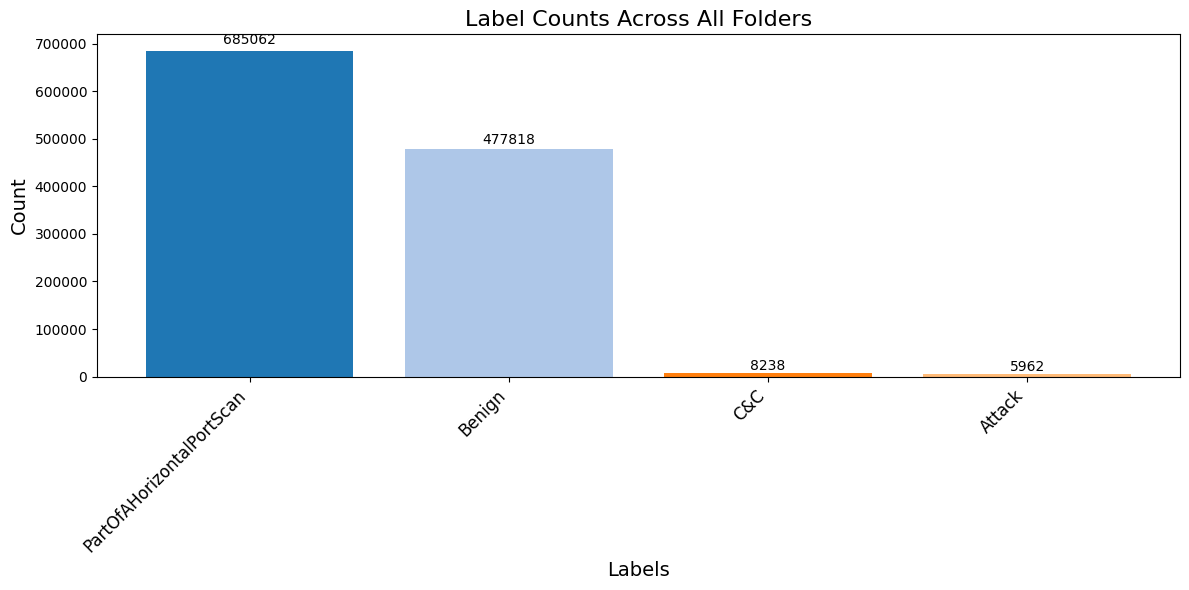

In [4]:
folders = ['ctu-1-1', 'ctu-3-1', 'ctu-4-1', 'ctu-5-1', 'ctu-8-1']
label_counts = {} 

for folder in folders:
    attack_file = f"{folder}/attack_data.csv"
    benign_file = f"{folder}/benign_data.csv"

    attack_df = pd.read_csv(attack_file)
    benign_df = pd.read_csv(benign_file)

    combined_df = pd.concat([attack_df, benign_df], ignore_index=True)

    labels_in_file = combined_df['label'].value_counts()

    for label, count in labels_in_file.items():
        if label in label_counts:
            label_counts[label] += count
        else:
            label_counts[label] = count

cleaned_label_counts = {}
for label, count in label_counts.items():
    clean_label = label.replace("(empty)   Malicious   ", "").replace("(empty)   ", "").strip()
    if "benign" in clean_label.lower():
        clean_label = "Benign"
    if clean_label in cleaned_label_counts:
        cleaned_label_counts[clean_label] += count
    else:
        cleaned_label_counts[clean_label] = count

label_df = pd.DataFrame(list(cleaned_label_counts.items()), columns=["Label", "Count"])

colors = plt.cm.tab20.colors[:len(label_df)]

plt.figure(figsize=(12, 6))
bars = plt.bar(label_df["Label"], label_df["Count"], color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Label Counts Across All Folders", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_19512\1352823258.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([attack_df, benign_df], ignore_index=True)
C:\Users\pc\AppData\Local\Temp\ipykernel_19512\1352823258.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([attack_df, benign_df], ignore_index=True)


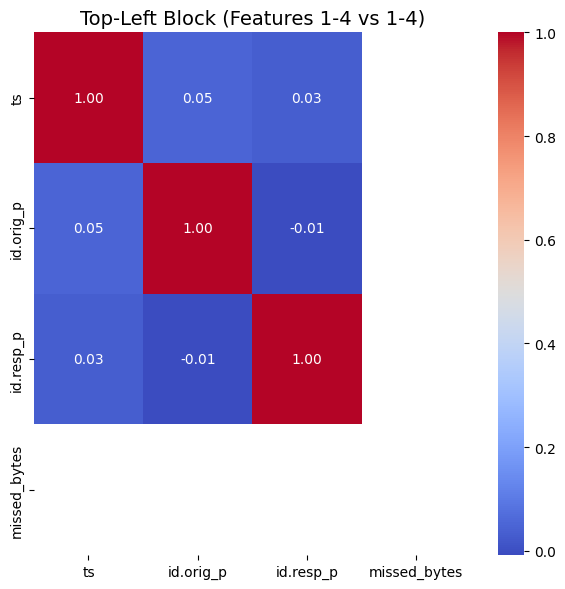

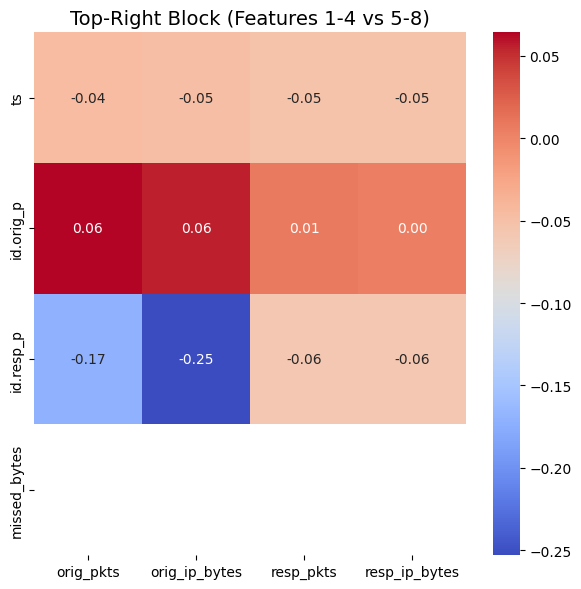

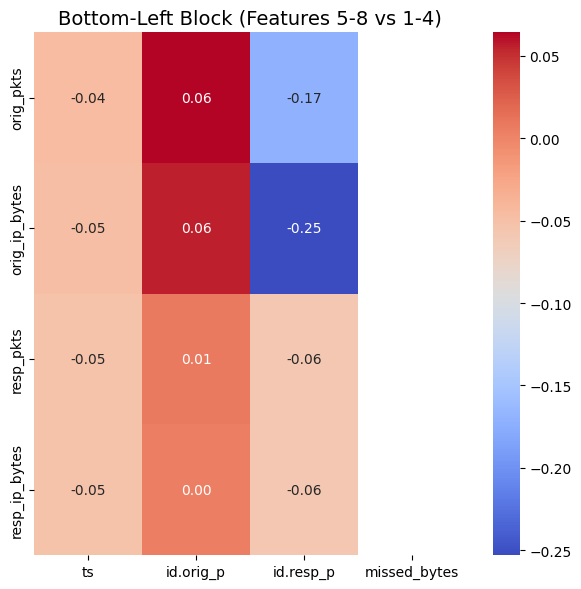

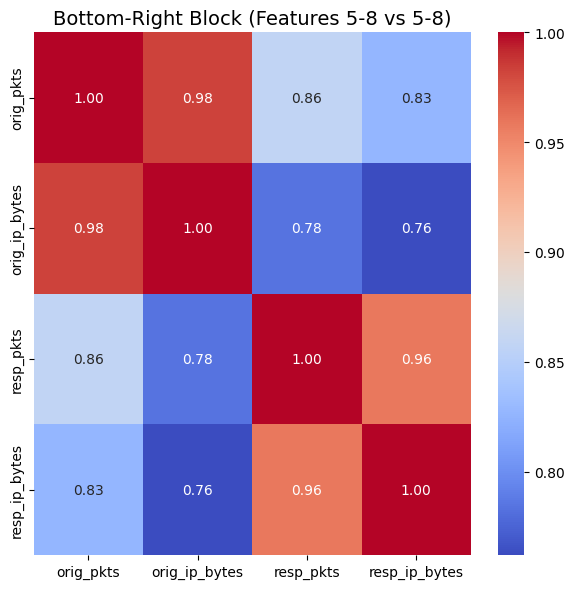

In [5]:
folders = ['ctu-1-1', 'ctu-3-1', 'ctu-4-1', 'ctu-5-1', 'ctu-8-1']

first_file_df = None
label_counts = {}

for folder in folders:
    attack_file = f"{folder}/attack_data.csv"
    benign_file = f"{folder}/benign_data.csv"

    attack_df = pd.read_csv(attack_file)
    benign_df = pd.read_csv(benign_file)

    combined_df = pd.concat([attack_df, benign_df], ignore_index=True)

    if first_file_df is None:
        first_file_df = combined_df

    labels_in_file = combined_df['label'].value_counts()

    for label, count in labels_in_file.items():
        if label in label_counts:
            label_counts[label] += count
        else:
            label_counts[label] = count

correlation_matrix = first_file_df.select_dtypes(include=['float64', 'int64']).corr()

block_1 = correlation_matrix.iloc[:4, :4]
block_2 = correlation_matrix.iloc[:4, 4:]
block_3 = correlation_matrix.iloc[4:, :4]
block_4 = correlation_matrix.iloc[4:, 4:]

def plot_correlation_block(block, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(block, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_correlation_block(block_1, "Top-Left Block (Features 1-4 vs 1-4)")
plot_correlation_block(block_2, "Top-Right Block (Features 1-4 vs 5-8)")
plot_correlation_block(block_3, "Bottom-Left Block (Features 5-8 vs 1-4)")
plot_correlation_block(block_4, "Bottom-Right Block (Features 5-8 vs 5-8)")

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


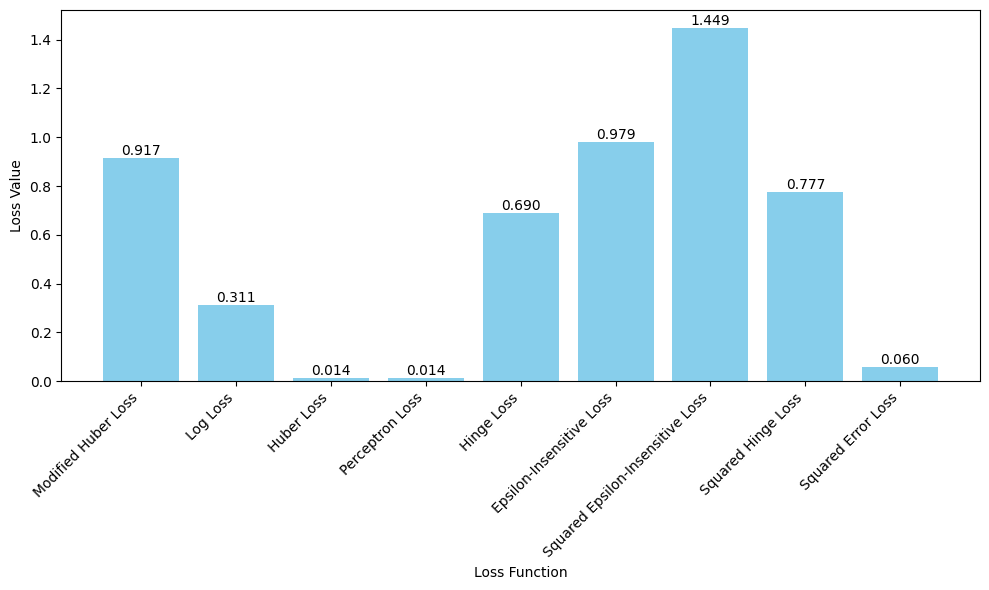

In [6]:
X, y = make_classification(n_samples=5000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "SGD (Modified Huber)": SGDClassifier(loss="modified_huber", random_state=42),
    "SGD (Hinge)": SGDClassifier(loss="hinge", random_state=42),
    "SGD (Perceptron)": SGDClassifier(loss="perceptron", random_state=42),
    "SGD (Huber)": SGDClassifier(loss="huber", epsilon=0.1, random_state=42),
    "Logistic Regression": LogisticRegression(solver="liblinear", random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(128,), max_iter=300, random_state=42)
}

results = {}

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    y_pred = model.predict(X_test)
    
    results[name] = {
        "training_time": training_time,
        "accuracy": accuracy_score(y_test, y_pred)
    }

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = None

    if "SGD" in name:
        if "Modified Huber" in name:
            results[name]["Modified Huber Loss"] = np.mean(
                np.maximum(0, 1 - y_test * y_pred_proba) +
                0.5 * np.maximum(0, 1 - y_test * y_pred_proba) ** 2
            )
        elif "Hinge" in name:
            results[name]["Hinge Loss"] = np.mean(np.maximum(0, 1 - y_test * y_pred_proba))
        elif "Perceptron" in name:
            results[name]["Perceptron Loss"] = np.mean(np.maximum(0, -y_test * y_pred_proba))
        elif "Huber" in name:
            results[name]["Huber Loss"] = np.mean(np.where(
                np.abs(y_test - y_pred) <= 0.1,  # Epsilon value
                0.5 * (y_test - y_pred) ** 2,
                0.1 * (np.abs(y_test - y_pred) - 0.5 * 0.1)
            ))
    if "Logistic Regression" in name or "MLP" in name:
        if y_pred_proba is not None:
            results[name]["Log Loss"] = log_loss(y_test, model.predict_proba(X_test))
    if "Gradient Boosting" in name or "Random Forest" in name or "AdaBoost" in name:
        if y_pred_proba is not None:
            results[name]["Squared Error Loss"] = mean_squared_error(y_test, y_pred_proba)

if "SVM" in results:
    epsilon = 0.1
    y_pred_svm = models["SVM"].decision_function(X_test)
    results["SVM"]["Epsilon-Insensitive Loss"] = np.mean(
        np.maximum(0, np.abs(y_test - y_pred_svm) - epsilon)
    )
    results["SVM"]["Squared Epsilon-Insensitive Loss"] = np.mean(
        np.maximum(0, np.abs(y_test - y_pred_svm) - epsilon) ** 2
    )
    results["SVM"]["Squared Hinge Loss"] = np.mean(np.maximum(0, 1 - y_test * y_pred_svm) ** 2)

loss_names = set()
for metrics in results.values():
    loss_names.update(metrics.keys())
loss_names = [loss for loss in loss_names if "Loss" in loss]

best_losses = {}
for loss in loss_names:
    best_value = float('inf')
    for model_name, metrics in results.items():
        if loss in metrics:
            best_value = min(best_value, metrics[loss])
    if best_value != float('inf'):
        best_losses[loss] = best_value

plt.figure(figsize=(10, 6))
bars = plt.bar(best_losses.keys(), best_losses.values(), color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center',va='bottom',fontsize=10, color='black')

plt.xlabel("Loss Function")
plt.ylabel("Loss Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [3]:
for col in df.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [4]:
X = df.drop(columns=['label'])
y = df['label']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
start_time = time.time()
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
training_time_rf = time.time() - start_time
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("Training Time: ", training_time_rf)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest
Training Time:  224.33868956565857
Accuracy: 0.9998300880144085
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     95470
           1       1.00      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      1.00      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [11]:
start_time = time.time()
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression")
print("Training Time: ", training_time_lr)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Training Time:  4.903329372406006
Accuracy: 0.8231513575967648
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.61      0.74     95470
           1       0.79      0.97      0.87    139946

    accuracy                           0.82    235416
   macro avg       0.86      0.79      0.80    235416
weighted avg       0.84      0.82      0.81    235416



In [12]:
start_time = time.time()
model_ab = AdaBoostClassifier(random_state=42)
model_ab.fit(X_train, y_train)
training_time_ab = time.time() - start_time
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("Training Time: ", training_time_ab)
print("Accuracy:", accuracy_score(y_test, y_pred_ab))
print("Classification Report:\n", classification_report(y_test, y_pred_ab))

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost
Training Time:  72.98079371452332
Accuracy: 0.9956375097699391
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     95470
           1       0.99      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      0.99      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [13]:
start_time = time.time()
model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)
training_time_sgd = time.time() - start_time
y_pred_sgd = model_sgd.predict(X_test)

print("SGD Classifier")
print("Training Time: ", training_time_sgd)
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Classifier
Training Time:  101.81535792350769
Accuracy: 0.4055374316104258
Classification Report:
               precision    recall  f1-score   support

           0       0.41      1.00      0.58     95470
           1       0.00      0.00      0.00    139946

    accuracy                           0.41    235416
   macro avg       0.20      0.50      0.29    235416
weighted avg       0.16      0.41      0.23    235416



c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [14]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

start_time = time.time()
model_svm = SVC(random_state=42, probability=True)
model_svm.fit(X_train_sample, y_train_sample)
training_time_svm = time.time() - start_time
y_pred_svm = model_svm.predict(X_test)

print("SVM")
print("Training Time: ", training_time_svm)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM
Training Time:  23.61923861503601
Accuracy: 0.5944625683895742


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     95470
           1       0.59      1.00      0.75    139946

    accuracy                           0.59    235416
   macro avg       0.30      0.50      0.37    235416
weighted avg       0.35      0.59      0.44    235416



c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
start_time = time.time()
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train)
training_time_gb = time.time() - start_time
y_pred_gb = model_gb.predict(X_test)

print("Gradient Boosting")
print("Training Time: ", training_time_gb)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))

Gradient Boosting
Training Time:  251.78492736816406
Accuracy: 0.9998810616100859
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     95470
           1       1.00      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      1.00      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [16]:
start_time = time.time()
model_mlp = MLPClassifier(hidden_layer_sizes=(128,), random_state=42, max_iter=300)
model_mlp.fit(X_train, y_train)
training_time_mlp = time.time() - start_time
y_pred_mlp = model_mlp.predict(X_test)

print("Neural Network (MLP)")
print("Training Time: ", training_time_mlp)
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network (MLP)
Training Time:  228.60090351104736
Accuracy: 0.7373543004723553
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.98      0.75     95470
           1       0.97      0.58      0.72    139946

    accuracy                           0.74    235416
   macro avg       0.79      0.78      0.74    235416
weighted avg       0.82      0.74      0.73    235416



In [17]:
start_time = time.time()

model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_dnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_dp = time.time() - start_time

y_pred_dnn = (model_dnn.predict(X_test) > 0.5).astype(int)

print("Deep Neural Network (DNN)")
print("Training Time: ", training_time_dp)
print("Accuracy:", accuracy_score(y_test, y_pred_dnn))
print("Classification Report:\n", classification_report(y_test, y_pred_dnn))

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.5729 - loss: 2216736.2500 - val_accuracy: 0.5945 - val_loss: 0.6752
Epoch 2/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5927 - loss: 217.9648 - val_accuracy: 0.5945 - val_loss: 0.6752
Epoch 3/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5929 - loss: 15.3342 - val_accuracy: 0.5945 - val_loss: 0.6752
Epoch 4/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5939 - loss: 3.8692 - val_accuracy: 0.5945 - val_loss: 0.6752
Epoch 5/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5936 - loss: 3.7196 - val_accuracy: 0.5945 - val_loss: 0.6752
Epoch 6/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5937 - loss: 4.2512 - val_accuracy: 0.5945 - val_loss: 0.6752
Epoch 7/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5943 - loss: 73.4073 - val_accuracy: 0.5945 - val_loss: 0.6752
Epoch 8/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - 

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     95470
           1       0.59      1.00      0.75    139946

    accuracy                           0.59    235416
   macro avg       0.30      0.50      0.37    235416
weighted avg       0.35      0.59      0.44    235416



c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
X_train_reshaped = np.expand_dims(X_train, axis=-1) 
X_test_reshaped = np.expand_dims(X_test, axis=-1)
start_time = time.time()

model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False), 
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn_lstm.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_cnn = time.time() - start_time

y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test_reshaped) > 0.5).astype(int)

print("CNN-LSTM")
print("Training Time: ", training_time_cnn)
print("Accuracy:", accuracy_score(y_test, y_pred_cnn_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_cnn_lstm))


Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11771/11771 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9557 - loss: 0.1604 - val_accuracy: 0.9607 - val_loss: 0.1402
Epoch 2/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9605 - loss: 0.1432 - val_accuracy: 0.9611 - val_loss: 0.1381
Epoch 3/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9613 - loss: 0.1420 - val_accuracy: 0.9620 - val_loss: 0.1408
Epoch 4/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9616 - loss: 0.1402 - val_accuracy: 0.9630 - val_loss: 0.1378
Epoch 5/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - accuracy: 0.9628 - loss: 0.1373 - val_accuracy: 0.9644 - val_loss: 0.1325
Epoch 6/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - accuracy: 0.9632 - loss: 0.1356 - val_accuracy: 0.9638 - val_loss: 0.1075
Epoch 7/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9629 - loss: 0.1304 - val_accuracy: 0.9632 - val_loss: 0.1327
Epoch 8/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9635 - lo

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train1, y_train1)

In [21]:
import time
start_time = time.time()
model_rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=10, max_features='sqrt')
model_rf.fit(X_train, y_train)
training_time_rfn = time.time() - start_time
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("Training Time: ", training_time_rfn)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest
Training Time:  94.75532984733582
Accuracy: 0.9944990994664764
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     95470
           1       0.99      1.00      1.00    139946

    accuracy                           0.99    235416
   macro avg       1.00      0.99      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [22]:
start_time = time.time()
model_lr = LogisticRegression(solver='liblinear', max_iter=200, random_state=42)
model_lr.fit(X_train, y_train)
training_time_lrn = time.time() - start_time
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression")
print("Training Time: ", training_time_lrn)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Training Time:  8.722066879272461
Accuracy: 0.9501010976314269
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94     95470
           1       0.95      0.97      0.96    139946

    accuracy                           0.95    235416
   macro avg       0.95      0.95      0.95    235416
weighted avg       0.95      0.95      0.95    235416



In [23]:
start_time = time.time()
model_ab = AdaBoostClassifier(random_state=42, n_estimators=50, learning_rate=0.2)
model_ab.fit(X_train, y_train)
training_time_abn = time.time() - start_time
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("Training Time: ", training_time_abn)
print("Accuracy:", accuracy_score(y_test, y_pred_ab))
print("Classification Report:\n", classification_report(y_test, y_pred_ab))

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost
Training Time:  88.49673819541931
Accuracy: 0.9919844020797227
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     95470
           1       0.99      1.00      0.99    139946

    accuracy                           0.99    235416
   macro avg       0.99      0.99      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [24]:
start_time = time.time()
model_sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
model_sgd.fit(X_train, y_train)
training_time_sgdn = time.time() - start_time
y_pred_sgd = model_sgd.predict(X_test)

print("SGD Classifier")
print("Training Time: ", training_time_sgdn)
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Classifier
Training Time:  1.6236686706542969
Accuracy: 0.9600621877867265
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     95470
           1       0.94      1.00      0.97    139946

    accuracy                           0.96    235416
   macro avg       0.97      0.95      0.96    235416
weighted avg       0.96      0.96      0.96    235416



In [25]:
start_time = time.time()
model_gb = GradientBoostingClassifier(random_state=42, n_estimators=50)
model_gb.fit(X_train, y_train)
training_time_gbn = time.time() - start_time
y_pred_gb = model_gb.predict(X_test)

print("Gradient Boosting")
print("Training Time: ", training_time_gbn)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting
Training Time:  179.73897171020508
Accuracy: 0.997791144187311
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     95470
           1       1.00      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      1.00      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [26]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

start_time = time.time()
model_svm = SVC(random_state=42, C=0.5, kernel='linear', probability=True)
model_svm.fit(X_train_sample, y_train_sample)
training_time_svmn = time.time() - start_time
y_pred_svm = model_svm.predict(X_test)

print("SVM")
print("Training Time: ", training_time_svmn)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM
Training Time:  5.551141738891602
Accuracy: 0.9600621877867265
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     95470
           1       0.94      1.00      0.97    139946

    accuracy                           0.96    235416
   macro avg       0.97      0.95      0.96    235416
weighted avg       0.96      0.96      0.96    235416



In [27]:
start_time = time.time()
model_mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=200, early_stopping=True, random_state=42)
model_mlp.fit(X_train, y_train)
training_time_mlpn = time.time() - start_time
y_pred_mlp = model_mlp.predict(X_test)

print("Neural Network (MLP)")
print("Training Time: ", training_time_mlpn)
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network (MLP)
Training Time:  209.39276790618896
Accuracy: 0.9957394569612941
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     95470
           1       0.99      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      0.99      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [28]:
from tensorflow.keras.callbacks import EarlyStopping
start_time = time.time()

model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_dnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_dpn = time.time() - start_time

y_pred_dnn = (model_dnn.predict(X_test) > 0.5).astype(int)

print("Deep Neural Network (DNN)")
print("Training Time: ", training_time_dpn)
print("Accuracy:", accuracy_score(y_test, y_pred_dnn))
print("Classification Report:\n", classification_report(y_test, y_pred_dnn))


Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11771/11771 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9838 - loss: 0.0649 - val_accuracy: 0.9934 - val_loss: 0.0328
Epoch 2/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9932 - loss: 0.0345 - val_accuracy: 0.9938 - val_loss: 0.0295
Epoch 3/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9933 - loss: 0.0317 - val_accuracy: 0.9936 - val_loss: 0.0283
Epoch 4/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9935 - loss: 0.0296 - val_accuracy: 0.9938 - val_loss: 0.0256
Epoch 5/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9935 - loss: 0.0287 - val_accuracy: 0.9939 - val_loss: 0.0248
Epoch 6/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9935 - loss: 0.0273 - val_accuracy: 0.9939 - val_loss: 0.0238
Epoch 7/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9937 - loss: 0.0263 - val_accuracy: 0.9940 - val_loss: 0.0231
Epoch 8/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9938 - lo

In [29]:
X_train_reshaped = np.expand_dims(X_train, axis=-1) 
X_test_reshaped = np.expand_dims(X_test, axis=-1)
start_time = time.time()

model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False), 
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# model_cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])

model_cnn_lstm.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_cnnn = time.time() - start_time

y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test_reshaped) > 0.5).astype(int)

print("CNN-LSTM")
print("Training Time: ", training_time_cnnn)
print("Accuracy:", accuracy_score(y_test, y_pred_cnn_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_cnn_lstm))


Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11771/11771 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.9747 - loss: 0.0768 - val_accuracy: 0.9932 - val_loss: 0.0348
Epoch 2/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - accuracy: 0.9932 - loss: 0.0353 - val_accuracy: 0.9924 - val_loss: 0.0360
Epoch 3/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.9937 - loss: 0.0326 - val_accuracy: 0.9941 - val_loss: 0.0270
Epoch 4/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.9944 - loss: 0.0267 - val_accuracy: 0.9960 - val_loss: 0.0225
Epoch 5/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9956 - loss: 0.0235 - val_accuracy: 0.9964 - val_loss: 0.0200
Epoch 6/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.9960 - loss: 0.0216 - val_accuracy: 0.9963 - val_loss: 0.0199
Epoch 7/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.9962 - loss: 0.0205 - val_accuracy: 0.9965 - val_loss: 0.0188
Epoch 8/10
11771/11771 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.9964 - lo

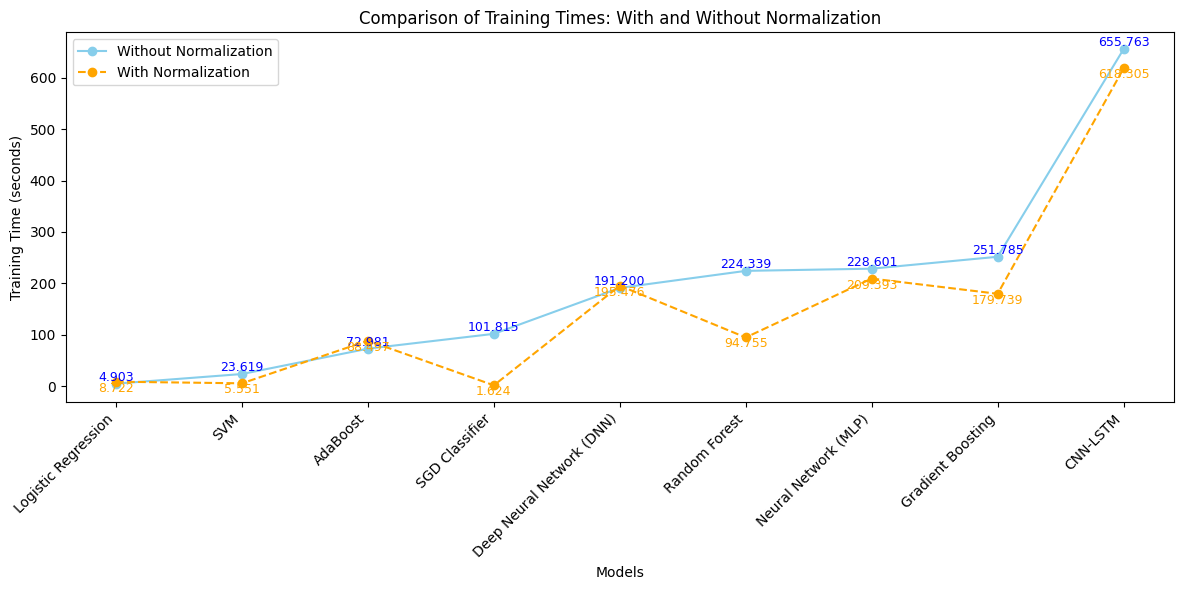

In [30]:
training_times = {
    "Random Forest": training_time_rf,
    "Logistic Regression": training_time_lr,
    "AdaBoost": training_time_ab,
    "SGD Classifier": training_time_sgd,
    "SVM": training_time_svm,
    "Neural Network (MLP)": training_time_mlp,
    "Deep Neural Network (DNN)": training_time_dp,
    "CNN-LSTM": training_time_cnn,
    "Gradient Boosting": training_time_gb
}

training_timesn = {
    "Random Forest": training_time_rfn,
    "Logistic Regression": training_time_lrn,
    "AdaBoost": training_time_abn,
    "SGD Classifier": training_time_sgdn,
    "SVM": training_time_svmn,
    "Neural Network (MLP)": training_time_mlpn,
    "Deep Neural Network (DNN)": training_time_dpn,
    "CNN-LSTM": training_time_cnnn,
    "Gradient Boosting": training_time_gbn
}

sorted_training_times = dict(sorted(training_times.items(), key=lambda x: x[1]))
sorted_training_timesn = {model: training_timesn[model] for model in sorted_training_times.keys()}

models = list(sorted_training_times.keys())
times_without_norm = list(sorted_training_times.values())
times_with_norm = list(sorted_training_timesn.values())

plt.figure(figsize=(12, 6))

plt.plot(models, times_without_norm, marker='o', linestyle='-', label='Without Normalization', color='skyblue')
plt.plot(models, times_with_norm, marker='o', linestyle='--', label='With Normalization', color='orange')

plt.xticks(rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Training Time (seconds)")
plt.title("Comparison of Training Times: With and Without Normalization")
plt.legend()
plt.tight_layout()

for i, (time_wn, time_n) in enumerate(zip(times_without_norm, times_with_norm)):
    plt.text(i, time_wn, f'{time_wn:.3f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, time_n, f'{time_n:.3f}', ha='center', va='top', fontsize=9, color='orange')

plt.show()


In [31]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [12 13] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [32]:
import time
start_time = time.time()
model_rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=10, max_features='sqrt')
model_rf.fit(X_train, y_train)
training_time_rfn = time.time() - start_time
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("Training Time: ", training_time_rfn)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest
Training Time:  87.44969701766968
Accuracy: 0.9945415774628742
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     95470
           1       0.99      1.00      1.00    139946

    accuracy                           0.99    235416
   macro avg       1.00      0.99      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [33]:
start_time = time.time()
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression")
print("Training Time: ", training_time_lr)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Training Time:  7.829632043838501
Accuracy: 0.9498632208515989
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     95470
           1       0.95      0.96      0.96    139946

    accuracy                           0.95    235416
   macro avg       0.95      0.95      0.95    235416
weighted avg       0.95      0.95      0.95    235416



In [34]:
start_time = time.time()
model_ab = AdaBoostClassifier(random_state=42)
model_ab.fit(X_train, y_train)
training_time_ab = time.time() - start_time
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("Training Time: ", training_time_ab)
print("Accuracy:", accuracy_score(y_test, y_pred_ab))
print("Classification Report:\n", classification_report(y_test, y_pred_ab))

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost
Training Time:  82.04076671600342
Accuracy: 0.9953359159955143
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     95470
           1       0.99      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      0.99      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [35]:
start_time = time.time()
model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)
training_time_sgd = time.time() - start_time
y_pred_sgd = model_sgd.predict(X_test)

print("SGD Classifier")
print("Training Time: ", training_time_sgd)
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Classifier
Training Time:  1.6783967018127441
Accuracy: 0.9558016447480205
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95     95470
           1       0.96      0.96      0.96    139946

    accuracy                           0.96    235416
   macro avg       0.95      0.95      0.95    235416
weighted avg       0.96      0.96      0.96    235416



In [36]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

start_time = time.time()
model_svm = SVC(random_state=42, probability=True)
model_svm.fit(X_train_sample, y_train_sample)
training_time_svm = time.time() - start_time
y_pred_svm = model_svm.predict(X_test)

print("SVM")
print("Training Time: ", training_time_svm)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM
Training Time:  2.012258529663086
Accuracy: 0.9866916437285486
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     95470
           1       0.98      1.00      0.99    139946

    accuracy                           0.99    235416
   macro avg       0.99      0.98      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [37]:
start_time = time.time()
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train)
training_time_gb = time.time() - start_time
y_pred_gb = model_gb.predict(X_test)

print("Gradient Boosting")
print("Training Time: ", training_time_gb)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))

Gradient Boosting
Training Time:  316.62346291542053
Accuracy: 0.9998810616100859
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     95470
           1       1.00      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      1.00      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [38]:
start_time = time.time()
model_mlp = MLPClassifier(hidden_layer_sizes=(128,), random_state=42, max_iter=300)
model_mlp.fit(X_train, y_train)
training_time_mlp = time.time() - start_time
y_pred_mlp = model_mlp.predict(X_test)

print("Neural Network (MLP)")
print("Training Time: ", training_time_mlp)
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network (MLP)
Training Time:  502.9044370651245
Accuracy: 0.9967291942773643
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     95470
           1       0.99      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      1.00      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [39]:
start_time = time.time()

model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_dnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_dp = time.time() - start_time

y_pred_dnn = (model_dnn.predict(X_test) > 0.5).astype(int)

print("Deep Neural Network (DNN)")
print("Training Time: ", training_time_dp)
print("Accuracy:", accuracy_score(y_test, y_pred_dnn))
print("Classification Report:\n", classification_report(y_test, y_pred_dnn))

Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13983/13983 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.9852 - loss: 0.0600 - val_accuracy: 0.9863 - val_loss: 0.0603
Epoch 2/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9935 - loss: 0.0326 - val_accuracy: 0.9870 - val_loss: 0.0486
Epoch 3/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9935 - loss: 0.0293 - val_accuracy: 0.9864 - val_loss: 0.0492
Epoch 4/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9935 - loss: 0.0276 - val_accuracy: 0.9874 - val_loss: 0.0406
Epoch 5/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9939 - loss: 0.0261 - val_accuracy: 0.9888 - val_loss: 0.0449
Epoch 6/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - accuracy: 0.9949 - loss: 0.0251 - val_accuracy: 0.9915 - val_loss: 0.0366
Epoch 7/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9954 - loss: 0.0240 - val_accuracy: 0.9916 - val_loss: 0.0367
Epoch 8/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9952 - lo

In [40]:
X_train_reshaped = np.expand_dims(X_train, axis=-1) 
X_test_reshaped = np.expand_dims(X_test, axis=-1)
start_time = time.time()

model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False), 
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn_lstm.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_cnn = time.time() - start_time

y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test_reshaped) > 0.5).astype(int)

print("CNN-LSTM")
print("Training Time: ", training_time_cnn)
print("Accuracy:", accuracy_score(y_test, y_pred_cnn_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_cnn_lstm))

Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13983/13983 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9796 - loss: 0.0646 - val_accuracy: 0.9869 - val_loss: 0.0599
Epoch 2/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.9938 - loss: 0.0321 - val_accuracy: 0.9877 - val_loss: 0.0467
Epoch 3/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.9953 - loss: 0.0235 - val_accuracy: 0.9914 - val_loss: 0.0390
Epoch 4/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9962 - loss: 0.0211 - val_accuracy: 0.9927 - val_loss: 0.0337
Epoch 5/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.9963 - loss: 0.0204 - val_accuracy: 0.9933 - val_loss: 0.0278
Epoch 6/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9973 - loss: 0.0144 - val_accuracy: 0.9938 - val_loss: 0.0284
Epoch 7/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9975 - loss: 0.0138 - val_accuracy: 0.9959 - val_loss: 0.0168
Epoch 8/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.9978 - lo

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [42]:
import time
start_time = time.time()
model_rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=10, max_features='sqrt')
model_rf.fit(X_train, y_train)
training_time_rfn = time.time() - start_time
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("Training Time: ", training_time_rfn)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest
Training Time:  270.7980115413666
Accuracy: 0.9927872362116423
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     95470
           1       0.99      1.00      0.99    139946

    accuracy                           0.99    235416
   macro avg       0.99      0.99      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [43]:
start_time = time.time()
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)
training_time_lr = time.time() - start_time
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression")
print("Training Time: ", training_time_lr)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Training Time:  5.904993534088135
Accuracy: 0.9495616270771741
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     95470
           1       0.95      0.96      0.96    139946

    accuracy                           0.95    235416
   macro avg       0.95      0.95      0.95    235416
weighted avg       0.95      0.95      0.95    235416



In [44]:
start_time = time.time()
model_ab = AdaBoostClassifier(random_state=42)
model_ab.fit(X_train, y_train)
training_time_ab = time.time() - start_time
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("Training Time: ", training_time_ab)
print("Accuracy:", accuracy_score(y_test, y_pred_ab))
print("Classification Report:\n", classification_report(y_test, y_pred_ab))

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost
Training Time:  247.20595574378967
Accuracy: 0.9870442110986509
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     95470
           1       0.98      1.00      0.99    139946

    accuracy                           0.99    235416
   macro avg       0.99      0.98      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [45]:
start_time = time.time()
model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)
training_time_sgd = time.time() - start_time
y_pred_sgd = model_sgd.predict(X_test)

print("SGD Classifier")
print("Training Time: ", training_time_sgd)
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Classifier
Training Time:  1.804572582244873
Accuracy: 0.9545655350528426
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     95470
           1       0.96      0.96      0.96    139946

    accuracy                           0.95    235416
   macro avg       0.95      0.95      0.95    235416
weighted avg       0.95      0.95      0.95    235416



In [46]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

start_time = time.time()
model_svm = SVC(random_state=42, probability=True)
model_svm.fit(X_train_sample, y_train_sample)
training_time_svm = time.time() - start_time
y_pred_svm = model_svm.predict(X_test)

print("SVM")
print("Training Time: ", training_time_svm)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM
Training Time:  2.5317702293395996
Accuracy: 0.9857104020117579
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     95470
           1       0.98      1.00      0.99    139946

    accuracy                           0.99    235416
   macro avg       0.99      0.98      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [47]:
start_time = time.time()
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train)
training_time_gb = time.time() - start_time
y_pred_gb = model_gb.predict(X_test)

print("Gradient Boosting")
print("Training Time: ", training_time_gb)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))

Gradient Boosting
Training Time:  1245.4412925243378
Accuracy: 0.9912792673395181
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     95470
           1       0.99      1.00      0.99    139946

    accuracy                           0.99    235416
   macro avg       0.99      0.99      0.99    235416
weighted avg       0.99      0.99      0.99    235416



In [48]:
start_time = time.time()
model_mlp = MLPClassifier(hidden_layer_sizes=(128,), random_state=42, max_iter=300)
model_mlp.fit(X_train, y_train)
training_time_mlp = time.time() - start_time
y_pred_mlp = model_mlp.predict(X_test)

print("Neural Network (MLP)")
print("Training Time: ", training_time_mlp)
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network (MLP)
Training Time:  610.1578254699707
Accuracy: 0.9966484860842084
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     95470
           1       0.99      1.00      1.00    139946

    accuracy                           1.00    235416
   macro avg       1.00      1.00      1.00    235416
weighted avg       1.00      1.00      1.00    235416



In [49]:
start_time = time.time()

model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_dnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_dp = time.time() - start_time

y_pred_dnn = (model_dnn.predict(X_test) > 0.5).astype(int)

print("Deep Neural Network (DNN)")
print("Training Time: ", training_time_dp)
print("Accuracy:", accuracy_score(y_test, y_pred_dnn))
print("Classification Report:\n", classification_report(y_test, y_pred_dnn))

Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13983/13983 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9846 - loss: 0.0612 - val_accuracy: 0.9863 - val_loss: 0.0605
Epoch 2/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9932 - loss: 0.0331 - val_accuracy: 0.9864 - val_loss: 0.0477
Epoch 3/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9934 - loss: 0.0306 - val_accuracy: 0.9865 - val_loss: 0.0500
Epoch 4/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9933 - loss: 0.0295 - val_accuracy: 0.9867 - val_loss: 0.0440
Epoch 5/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9934 - loss: 0.0281 - val_accuracy: 0.9868 - val_loss: 0.0416
Epoch 6/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9935 - loss: 0.0269 - val_accuracy: 0.9871 - val_loss: 0.0425
Epoch 7/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9935 - loss: 0.0264 - val_accuracy: 0.9869 - val_loss: 0.0408
Epoch 8/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9936 - lo

In [50]:
X_train_reshaped = np.expand_dims(X_train, axis=-1) 
X_test_reshaped = np.expand_dims(X_test, axis=-1)
start_time = time.time()

model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False), 
    Dropout(0.3),
    Dense(1, activation='sigmoid') 
])

model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn_lstm.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
training_time_cnn = time.time() - start_time

y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test_reshaped) > 0.5).astype(int)

print("CNN-LSTM")
print("Training Time: ", training_time_cnn)
print("Accuracy:", accuracy_score(y_test, y_pred_cnn_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_cnn_lstm))


Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13983/13983 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.9716 - loss: 0.0830 - val_accuracy: 0.9838 - val_loss: 0.0648
Epoch 2/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9919 - loss: 0.0387 - val_accuracy: 0.9865 - val_loss: 0.0594
Epoch 3/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - accuracy: 0.9926 - loss: 0.0365 - val_accuracy: 0.9865 - val_loss: 0.0530
Epoch 4/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9932 - loss: 0.0332 - val_accuracy: 0.9855 - val_loss: 0.0542
Epoch 5/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9932 - loss: 0.0324 - val_accuracy: 0.9860 - val_loss: 0.0528
Epoch 6/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9935 - loss: 0.0310 - val_accuracy: 0.9866 - val_loss: 0.0476
Epoch 7/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.9935 - loss: 0.0298 - val_accuracy: 0.9866 - val_loss: 0.0459
Epoch 8/10
13983/13983 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - accuracy: 0.9935 - lo

In [8]:
#Pearson Correlation

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
correlation_matrix = X_scaled_df.corr(method='pearson')
print(correlation_matrix)

                     ts           uid  id.orig_h  id.orig_p  id.resp_h  id.resp_p     proto   service  duration  orig_bytes  resp_bytes  conn_state  local_orig  local_resp  missed_bytes   history  orig_pkts  orig_ip_bytes  resp_pkts  resp_ip_bytes
ts             1.000000  8.502598e-04  -0.009316  -0.051294  -0.065670  -0.102389 -0.079037  0.118977  0.066037    0.194245    0.214329    0.129080         NaN         NaN      0.035084  0.082343   0.072820   1.229848e-01   0.043680       0.062469
uid            0.000850  1.000000e+00   0.001599  -0.000223  -0.000495  -0.001094 -0.000515 -0.000504  0.000352    0.000378    0.000820    0.000434         NaN         NaN      0.000659 -0.000922   0.000336   8.884884e-07   0.000083      -0.000120
id.orig_h     -0.009316  1.599161e-03   1.000000  -0.051597  -0.003472  -0.021491 -0.077752 -0.001261 -0.016791   -0.001741   -0.002947   -0.166978         NaN         NaN     -0.000072 -0.027878  -0.011711  -2.289119e-02  -0.001831      -0.002000
id.orig_

In [10]:
threshold = 0.9
high_corr_pairs = np.where(np.abs(correlation_matrix) > threshold)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j]) 
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]

print("Highly correlated pairs of features:", high_corr_pairs)

Highly correlated pairs of features: [('orig_pkts', 'orig_ip_bytes')]


In [11]:
features_to_drop = set()
for feature_a, feature_b in high_corr_pairs:
    features_to_drop.add(feature_b)  # Arbitrarily drop one of the two

X_filtered = X_scaled_df.drop(columns=list(features_to_drop))

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy after filtering highly correlated features:", accuracy)

Model accuracy after filtering highly correlated features: 0.9998853094097258


In [19]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.9480664016039692


In [20]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print("SGD Classifier Accuracy:", accuracy_score(y_test, y_pred))

SGD Classifier Accuracy: 0.9599984707921296


In [21]:
adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred))

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.9956375097699391


In [22]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred))

Gradient Boosting Accuracy: 0.9998810616100859


In [15]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train_sample, y_train_sample)

y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))

SVM Accuracy: 0.9600494443878071


In [12]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred))

Neural Network Accuracy: 0.9960750331328372


In [13]:
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

# Compile the model
dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
dnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate
dnn_loss, dnn_accuracy = dnn.evaluate(X_test, y_test)
print("DNN Accuracy:", dnn_accuracy)

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - accuracy: 0.9885 - loss: 0.0480 - val_accuracy: 0.9936 - val_loss: 0.0262
Epoch 2/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - accuracy: 0.9944 - loss: 0.0244 - val_accuracy: 0.9957 - val_loss: 0.0220
Epoch 3/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - accuracy: 0.9956 - loss: 0.0224 - val_accuracy: 0.9961 - val_loss: 0.0227
Epoch 4/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - accuracy: 0.9960 - loss: 0.0211 - val_accuracy: 0.9965 - val_loss: 0.0234
Epoch 5/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - accuracy: 0.9964 - loss: 0.0197 - val_accuracy: 0.9966 - val_loss: 0.0180
Epoch 6/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - accuracy: 0.9965 - loss: 0.0192 - val_accuracy: 0.9967 - val_loss: 0.0177
Epoch 7/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - accuracy: 0.9965 - loss: 0.0195 - val_accuracy: 0.9967 - val_loss: 0.0191
Epoch 8/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - accuracy: 

In [14]:
from tensorflow.keras.layers import Flatten

X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN-LSTM Model
cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=True),
    Flatten(),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

# Compile the model
cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate
cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm.evaluate(X_test_reshaped, y_test)
print("CNN-LSTM Accuracy:", cnn_lstm_accuracy)

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - accuracy: 0.9803 - loss: 0.0650 - val_accuracy: 0.9938 - val_loss: 0.0324
Epoch 2/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - accuracy: 0.9938 - loss: 0.0326 - val_accuracy: 0.9924 - val_loss: 0.0382
Epoch 3/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - accuracy: 0.9938 - loss: 0.0314 - val_accuracy: 0.9924 - val_loss: 0.0303
Epoch 4/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - accuracy: 0.9944 - loss: 0.0266 - val_accuracy: 0.9961 - val_loss: 0.0242
Epoch 5/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - accuracy: 0.9957 - loss: 0.0229 - val_accuracy: 0.9963 - val_loss: 0.0206
Epoch 6/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - accuracy: 0.9962 - loss: 0.0204 - val_accuracy: 0.9964 - val_loss: 0.0200
Epoch 7/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - accuracy: 0.9964 - loss: 0.0195 - val_accuracy: 0.9963 - val_loss: 0.0192
Epoch 8/20
23542/23542 ━━━━━━━━━━━━━━━━━━━━ 110s 5ms/step - ac